In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/assembly_values.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [11]:
print(assembly_values[100:199])

[{'month': '1980-02', 'inchi': 'InChI=1S/C18H15O3P/c1-4-10-16(11-5-1)19-22(20-17-12-6-2-7-13-17)21-18-14-8-3-9-15-18/h1-15H', 'ai': 13}, {'month': '1980-02', 'inchi': 'InChI=1S/C9H8O2/c1-2-7-3-5-8(6-4-7)9(10)11/h2-6H,1H2,(H,10,11)', 'ai': 7}, {'month': '1980-02', 'inchi': 'InChI=1S/C6H8O2/c1-3-5-8-6(7)4-2/h3-4H,1-2,5H2', 'ai': 5}, {'month': '1980-02', 'inchi': 'InChI=1S/C16H13N/c17-16-14-9-5-4-8-13(14)10-11-15(16)12-6-2-1-3-7-12/h1-11H,17H2', 'ai': 11}, {'month': '1980-02', 'inchi': 'InChI=1S/C8H16O2.K/c1-3-5-6-7(4-2)8(9)10;/h7H,3-6H2,1-2H3,(H,9,10);/q;+1/p-1', 'ai': 6}, {'month': '1980-02', 'inchi': 'InChI=1S/C17H36O/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18/h18H,2-17H2,1H3', 'ai': 6}, {'month': '1980-02', 'inchi': 'InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-2-4-6-9/h2-7,11H,1H3', 'ai': 10}, {'month': '1980-02', 'inchi': 'InChI=1S/C8H8O4S/c1-13(11,12)7-4-2-6(3-5-7)8(9)10/h2-5H,1H3,(H,9,10)', 'ai': 10}, {'month': '1980-02', 'inchi': 'InChI=1S/C6H9NO2/c1-2-6(8)9-5-3-4-7/h2-4H,1,5

In [6]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [7]:
months = build_month_increments(1980, 2019)

## Assembly values Analysis

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

In [14]:
#Create a dictionary of months & assembly indices
month_ais = {}

for month in tqdm(months):
    ais = []
    for cpd in assembly_values:
        if cpd["month"] == month:
            ais.append(cpd["ai"])
           
    month_ais[month] = ais
    


100%|███████████████████████████████████████████████████████████████████████████████| 480/480 [00:02<00:00, 198.22it/s]


In [17]:
#Find average & standard deviation for each month
month_avgs = []
month_stds = []
for month, ais in month_ais.items():
    month_avgs.append(np.mean(ais))
    month_stds.append(np.std(ais))


## Assembly values plotting

Plot mean, standard deviation, other data for each month

Text(0, 0.5, 'Assembly Index')

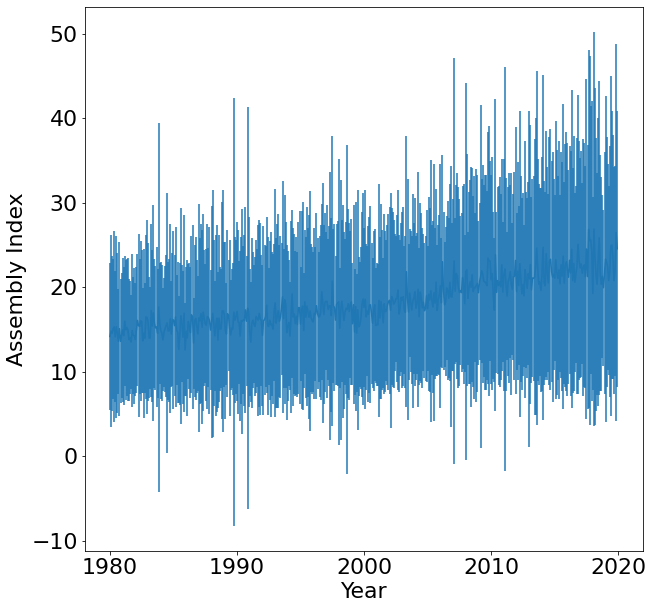

In [31]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))
plt.errorbar(np.arange(1980, 2020, 1/12), month_avgs, yerr=month_stds)

plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

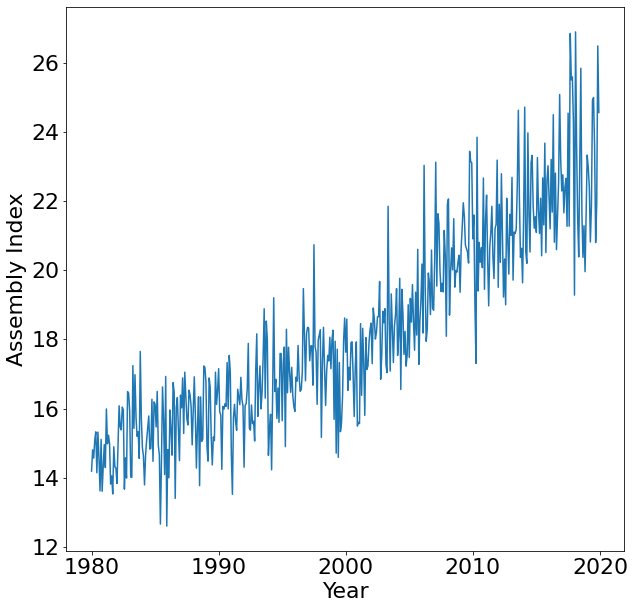

In [32]:
#Assembly values without standard deviation
plt.figure(figsize=(10,10))
plt.plot(np.arange(1980, 2020, 1/12), month_avgs)

plt.xlabel("Year")
plt.ylabel("Assembly Index")